영화진흥위원회 오픈API를 이용하여 데이터를 수집하였습니다.

주간 박스오피스 데이터와 영화목록 데이터 이렇게 두 종류의 데이터를 수집하였습니다.

아래의 코드는 주간 박스오피스 데이터를 가져오는 코드입니다.

주간 박스오피스 API 정보는 아래 사진과 같습니다.(참조 링크: https://www.kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do)

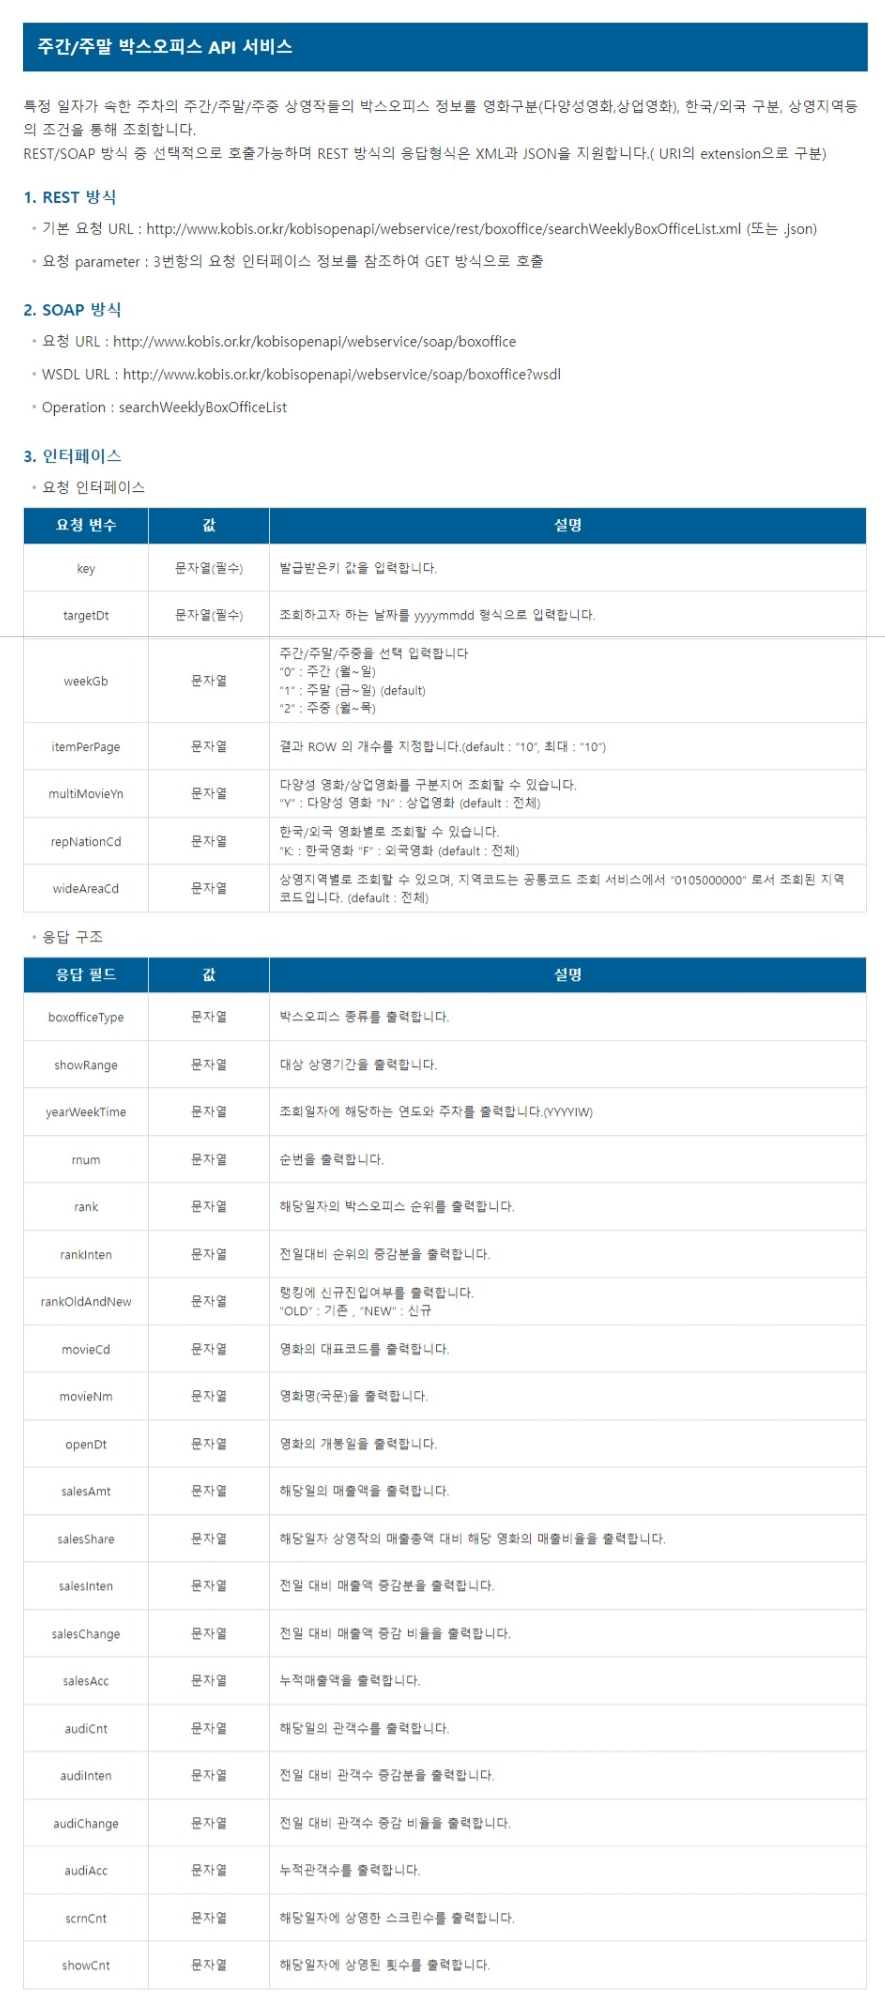

In [1]:
#2023년 1월 1일부터 20주간의 주간 박스오피스 데이터를 가져옴
import requests
import json
import datetime
import pandas as pd

current_datetime = datetime.datetime(2023, 1, 1)
data = []

for i in range(20):
    targetDt = current_datetime.strftime('%Y%m%d')
    url = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchWeeklyBoxOfficeList.json?key=f50cf6ad73b5104d7b2039cec6144b20&targetDt=' + targetDt + '&weekGb=0'
    res = requests.get(url)
    text = res.text

    d = json.loads(text)

    for b in d['boxOfficeResult']['weeklyBoxOfficeList']:
        movie_data = {
            'Date': targetDt,
            'Rank': b['rank'],
            'RankOldAndNew': b['rankOldAndNew'],
            'MovieCode': b['movieCd'],
            'MovieName': b['movieNm'],
            'SalesAmount': b['salesAmt'],
            'AudienceCount': b['audiCnt'],
            'openDt': b['openDt']
        }
        data.append(movie_data)

    current_datetime = current_datetime + datetime.timedelta(days=7)

weeklyBoxOffice = pd.DataFrame(data)

In [2]:
weeklyBoxOffice.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23


영화정보를 가져와 보겠습니다.

영화목록 API 정보는 아래 사진과 같습니다.(참조 링크: https://www.kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do)

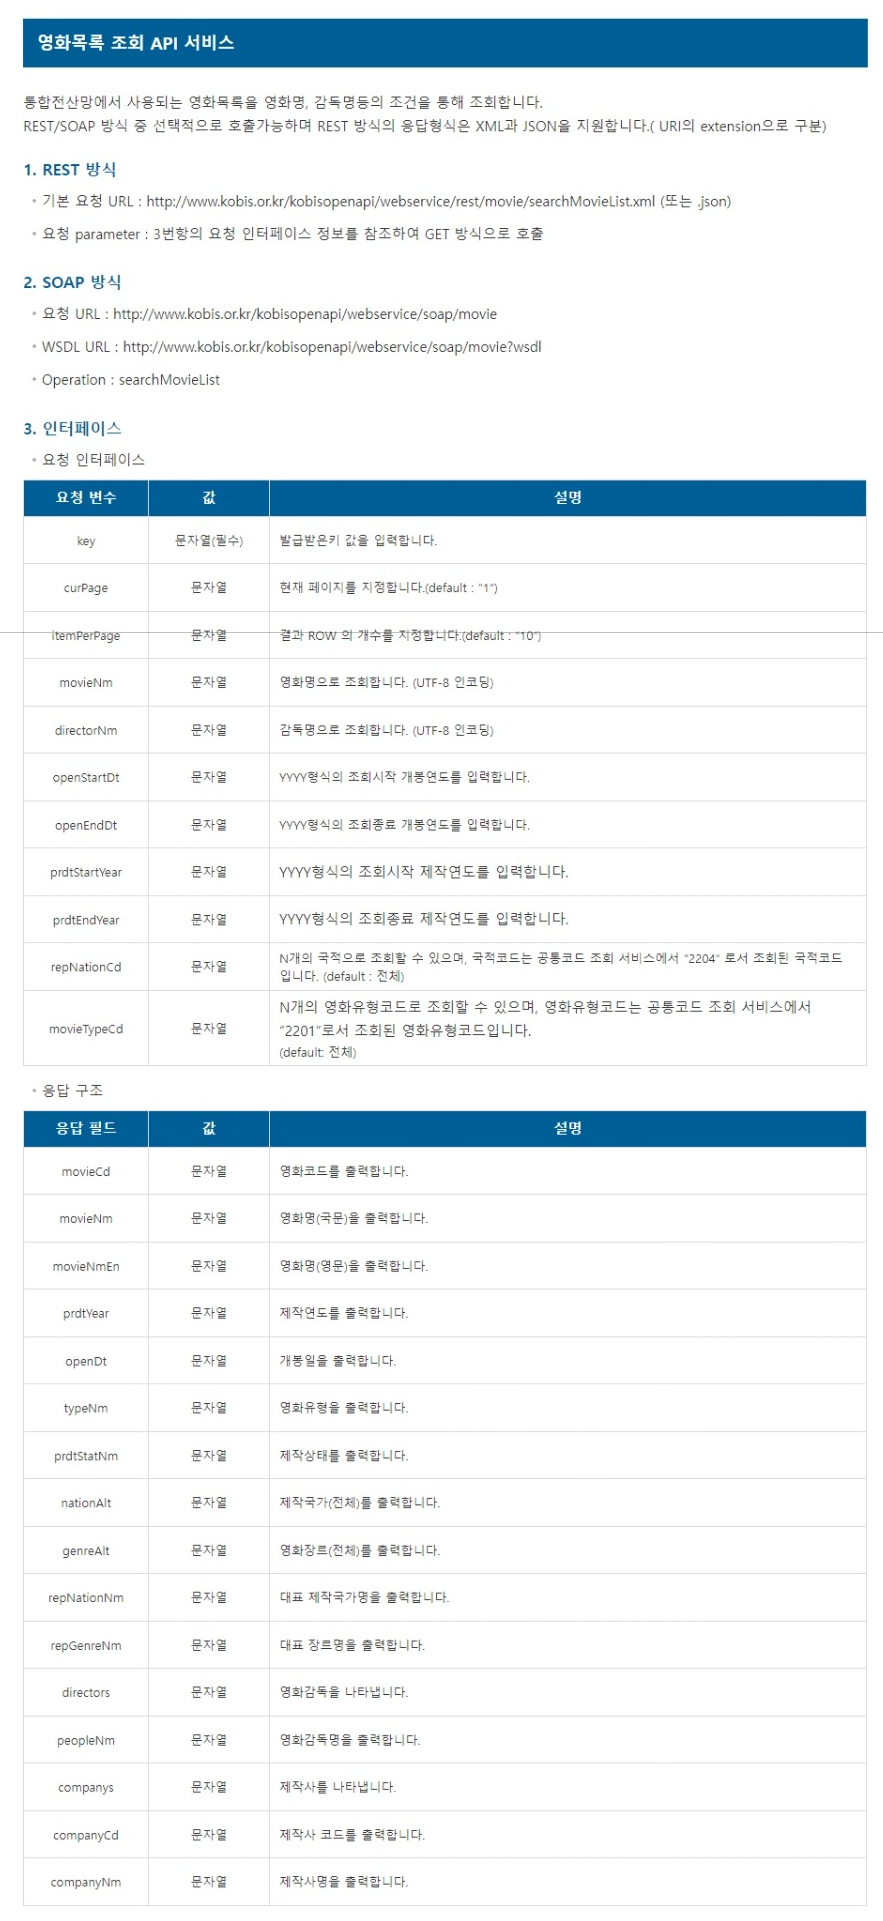

In [3]:
import warnings

# FutureWarning 제거
warnings.simplefilter(action='ignore', category=FutureWarning)

# 영화목록 API 호출(영화정보 가져옴) 및 데이터 가져오기 함수
def get_movie_info(api_key, movie_name):
    url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key={api_key}&movieNm={movie_name}"
    response = requests.get(url)
    data = response.json()

    if 'movieListResult' in data:
        movie_list = data['movieListResult']['movieList']
        if movie_list:
            movie_info = movie_list[0]
            return {
                'movieCd': movie_info.get('movieCd'),
                'movieNm': movie_info.get('movieNm'),
                'movieNmEn': movie_info.get('movieNmEn'),
                'prdtYear': movie_info.get('prdtYear'),
                'openDt': movie_info.get('openDt'),
                'typeNm': movie_info.get('typeNm'),
                'prdtStatNm': movie_info.get('prdtStatNm'),
                'nationAlt': movie_info.get('nationAlt'),
                'genreAlt': movie_info.get('genreAlt'),
                'repNationNm': movie_info.get('repNationNm'),
                'repGenreNm': movie_info.get('repGenreNm'),
                'directors': movie_info.get('directors'),
                'peopleNm': movie_info.get('peopleNm'),
                'companys': movie_info.get('companys'),
                'companyCd': movie_info.get('companyCd'),
                'companyNm': movie_info.get('companyNm')
            }

    # 정보가 없는 경우 None 반환
    return None

# 영화정보를 저장할 빈 데이터프레임 생성
movie_info = pd.DataFrame(columns=[
    'movieCd', 'movieNm', 'movieNmEn', 'prdtYear', 'openDt', 'typeNm', 'prdtStatNm',
    'nationAlt', 'genreAlt', 'repNationNm', 'repGenreNm', 'directors', 'peopleNm',
    'companys', 'companyCd', 'companyNm'
])


# 주간 박스오피스 순위 데이터프레임의 각 행에 대해 영화정보 추가
for index, row in weeklyBoxOffice.iterrows():
    movie_name = row['MovieName']
    movie_info_row = get_movie_info(api_key='f50cf6ad73b5104d7b2039cec6144b20', movie_name=movie_name)

    if movie_info_row is not None:
        # 영화 정보가 이미 존재하는지 확인
        existing_movie_info = movie_info[movie_info['movieCd'] == movie_info_row['movieCd']]
        if existing_movie_info.empty:
            # 영화 정보를 추가
            movie_info = movie_info.append(movie_info_row, ignore_index=True)

# 결과 확인
movie_info.head()


,movieCd,movieNm,movieNmEn,prdtYear,openDt,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
0,20225061,아바타: 물의 길,Avatar: The Way of Water,2022,20221214,장편,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],None,[],None,None
1,20232046,잊혀진 영웅들,Forgotten War,2023,,장편,기타,한국,다큐멘터리,한국,다큐멘터리,[],None,[],None,None
2,20210140,젠틀맨,Gentleman,2021,20221228,장편,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],None,"[{'companyCd': '20218082', 'companyNm': '(주)트릭...",None,None
3,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",Even If This Love Disappears from the World To...,2022,20221130,장편,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],None,[],None,None
4,20227762,올빼미,The Night Owl,2021,20221123,장편,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],None,"[{'companyCd': '20123218', 'companyNm': '(주)씨제...",None,None


In [4]:
# 주간 박스오피스 순위 데이터프레임과 영화정보 데이터프레임 JOIN
result = pd.merge(weeklyBoxOffice, movie_info, left_on='MovieCode', right_on='movieCd', how='left')

# 중복된 컬럼 제거
result.drop('movieCd', axis=1, inplace=True)

# 결과 확인
result.head()


,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt_x,movieNm,movieNmEn,...,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,아바타: 물의 길,Avatar: The Way of Water,...,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],None,[],None,None
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,젠틀맨,Gentleman,...,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],None,"[{'companyCd': '20218082', 'companyNm': '(주)트릭...",None,None
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",Even If This Love Disappears from the World To...,...,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],None,[],None,None
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,올빼미,The Night Owl,...,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],None,"[{'companyCd': '20123218', 'companyNm': '(주)씨제...",None,None


In [5]:
#result.to_csv('result.csv', index=False)

In [6]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           200 non-null    object
 1   Rank           200 non-null    object
 2   RankOldAndNew  200 non-null    object
 3   MovieCode      200 non-null    object
 4   MovieName      200 non-null    object
 5   SalesAmount    200 non-null    object
 6   AudienceCount  200 non-null    object
 7   openDt_x       200 non-null    object
 8   movieNm        181 non-null    object
 9   movieNmEn      181 non-null    object
 10  prdtYear       181 non-null    object
 11  openDt_y       181 non-null    object
 12  typeNm         181 non-null    object
 13  prdtStatNm     181 non-null    object
 14  nationAlt      181 non-null    object
 15  genreAlt       181 non-null    object
 16  repNationNm    181 non-null    object
 17  repGenreNm     181 non-null    object
 18  directors      181 non-null   

주간 박스오피스 순위 데이터프레임과 영화정보 데이터프레임을 JOIN한 result 데이터프레임을 확인해보니, 19개의 행의 데이터에서 결측치가 발견되었습니다.

movie_info를 확인해본 결과, 몇몇 영화가 정상적으로 추가되지 않았습니다. 

In [7]:
filtered_rows = result[result['movieNm'].isna()]

movie_name = filtered_rows['MovieName']

In [8]:
movie_name

1                      영웅
11                     영웅
22                     영웅
29                     유령
33                     유령
34                     영웅
43                     유령
44                     영웅
55                     영웅
56                     유령
65                     영웅
67                     유령
77                     영웅
116    에브리씽 에브리웨어 올 앳 원스+
126    에브리씽 에브리웨어 올 앳 원스+
138    에브리씽 에브리웨어 올 앳 원스+
143                    에어
155                    에어
199               너의 이름은.
Name: MovieName, dtype: object

확인해본 결과, '영웅', '유령', '에브리씽 에브리웨어 올 앳 원스+', '에어', '너의 이름은.' 이 5가지의 영화 정보를 가져오지 못하였습니다.

그 원인을 분석해본 결과, 정확하게 일치하는 영화 제목이 검색되지 않았습니다.

예를 들어, 주간 박스오피스 순위에 있는 영화 제목은 '영웅'이지만, 실제로 movie_info에 추가된 것은 '영웅'이라는 글자가 들어가는 전혀 다른 영화인 '잊혀진 영웅들'이었습니다.

그리고, '에브리씽 에브리웨어 올 앳 원스+'라는 영화 제목의 마지막에 '+'가 붙어있지만, 실제로 영화 제목에는 '+'가 붙지 않았습니다.

이에 대하여 API를 이용한 조회 시 제목이 정확히 일치하는 영화정보를 출력하고자 하였지만, 마땅한 방법을 찾지 못하였습니다.

그래서 이 5개의 영화만 별개로 감독 이름도 같이 검색하여 정보를 가져왔습니다.

In [9]:
# 영화목록 API 호출(영화정보 가져옴) 및 데이터 가져오기 함수
def get_movie_info_director(api_key, movie_name, director_name):
    url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key={api_key}&movieNm={movie_name}&directorNm={director_name}"
    response = requests.get(url)
    data = response.json()

    if 'movieListResult' in data:
        movie_list = data['movieListResult']['movieList']
        if movie_list:
            movie_info = movie_list[0]
            return {
                'movieCd': movie_info.get('movieCd'),
                'movieNm': movie_info.get('movieNm'),
                'movieNmEn': movie_info.get('movieNmEn'),
                'prdtYear': movie_info.get('prdtYear'),
                'openDt': movie_info.get('openDt'),
                'typeNm': movie_info.get('typeNm'),
                'prdtStatNm': movie_info.get('prdtStatNm'),
                'nationAlt': movie_info.get('nationAlt'),
                'genreAlt': movie_info.get('genreAlt'),
                'repNationNm': movie_info.get('repNationNm'),
                'repGenreNm': movie_info.get('repGenreNm'),
                'directors': movie_info.get('directors'),
                'peopleNm': movie_info.get('peopleNm'),
                'companys': movie_info.get('companys'),
                'companyCd': movie_info.get('companyCd'),
                'companyNm': movie_info.get('companyNm')
            }

    # 정보가 없는 경우 None 반환
    return None

# 5가지 영화에 대한 제목, 감독명 데이터프레임 생성
movie_name_director = pd.DataFrame({'MovieName': ['영웅', '유령', '에브리씽 에브리웨어 올 앳 원스+', '에어', '너의 이름은.'], 
                                    'Director': ['윤제균', '이해영', '다니엘 콴', '벤 애플렉', '신카이 마코토']})


# 주간 박스오피스 순위 데이터프레임의 각 행에 대해 영화정보 추가
for index, row in movie_name_director.iterrows():
    movie_name = row['MovieName']
    director_name = row['Director']
    movie_info_row = get_movie_info_director(api_key='f50cf6ad73b5104d7b2039cec6144b20', movie_name=movie_name, director_name=director_name)
    movie_info = movie_info.append(movie_info_row, ignore_index=True)

# 결과 확인
movie_info.tail()

,movieCd,movieNm,movieNmEn,prdtYear,openDt,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
64,20196478,영웅,Hero,2022,20221221,장편,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],None,"[{'companyCd': '20100278', 'companyNm': '(주)제이...",None,None
65,20214823,유령,Phantom,2022,20230118,장편,개봉,한국,액션,한국,액션,[{'peopleNm': '이해영'}],None,"[{'companyCd': '20124216', 'companyNm': '더램프(주...",None,None
66,20226798,에브리씽 에브리웨어 올 앳 원스,Everything Everywhere All At Once,2022,20221012,장편,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
67,20231010,에어,Air,2023,20230405,장편,개봉,미국,드라마,미국,드라마,[{'peopleNm': '벤 애플렉'}],None,[],None,None
68,20161872,너의 이름은.,your name.,2016,20170104,장편,개봉,일본,"애니메이션,드라마,멜로/로맨스",일본,애니메이션,[{'peopleNm': '신카이 마코토'}],None,[],None,None


In [10]:
movie_info.tail()

,movieCd,movieNm,movieNmEn,prdtYear,openDt,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
64,20196478,영웅,Hero,2022,20221221,장편,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],None,"[{'companyCd': '20100278', 'companyNm': '(주)제이...",None,None
65,20214823,유령,Phantom,2022,20230118,장편,개봉,한국,액션,한국,액션,[{'peopleNm': '이해영'}],None,"[{'companyCd': '20124216', 'companyNm': '더램프(주...",None,None
66,20226798,에브리씽 에브리웨어 올 앳 원스,Everything Everywhere All At Once,2022,20221012,장편,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
67,20231010,에어,Air,2023,20230405,장편,개봉,미국,드라마,미국,드라마,[{'peopleNm': '벤 애플렉'}],None,[],None,None
68,20161872,너의 이름은.,your name.,2016,20170104,장편,개봉,일본,"애니메이션,드라마,멜로/로맨스",일본,애니메이션,[{'peopleNm': '신카이 마코토'}],None,[],None,None


누락된 영화 정보를 가져오는데 성공했습니다.

이제, 이 movie_info를 이용하여 다시 JOIN하겠습니다. 이번에는 영화 코드가 아닌, 영화 제목으로 JOIN하도록 하겠습니다.

그에 앞서, weeklyBoxOffice 데이터프레임의 '에브리씽 에브리웨어 올 앳 원스'의 제목을 변경해주겠습니다.

In [11]:
weeklyBoxOffice.loc[result['MovieName'] == '에브리씽 에브리웨어 올 앳 원스+', 'MovieName'] = '에브리씽 에브리웨어 올 앳 원스'

In [12]:
# 주간 박스오피스 순위 데이터프레임과 영화정보 데이터프레임 JOIN
result = pd.merge(weeklyBoxOffice, movie_info, left_on='MovieName', right_on='movieNm', how='left')

# 중복된 컬럼 제거
result.drop(['movieNm', 'movieCd'], axis=1, inplace=True)

# 결과 확인
result.head()


,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt_x,movieNmEn,prdtYear,...,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,...,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],None,[],None,None
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,...,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],None,"[{'companyCd': '20100278', 'companyNm': '(주)제이...",None,None
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,...,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],None,"[{'companyCd': '20218082', 'companyNm': '(주)트릭...",None,None
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,...,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],None,[],None,None
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,...,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],None,"[{'companyCd': '20123218', 'companyNm': '(주)씨제...",None,None


In [13]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 202
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           203 non-null    object
 1   Rank           203 non-null    object
 2   RankOldAndNew  203 non-null    object
 3   MovieCode      203 non-null    object
 4   MovieName      203 non-null    object
 5   SalesAmount    203 non-null    object
 6   AudienceCount  203 non-null    object
 7   openDt_x       203 non-null    object
 8   movieNmEn      203 non-null    object
 9   prdtYear       203 non-null    object
 10  openDt_y       203 non-null    object
 11  typeNm         203 non-null    object
 12  prdtStatNm     203 non-null    object
 13  nationAlt      203 non-null    object
 14  genreAlt       203 non-null    object
 15  repNationNm    203 non-null    object
 16  repGenreNm     203 non-null    object
 17  directors      203 non-null    object
 18  peopleNm       0 non-null     

결측치가 사라졌지만, 왠지 모르게 행이 3개가 추가되었습니다.

정보가 누락된 5개의 영화 중 '에브리씽 에브리웨어 올 앳 원스'가 weeklyBoxOffice에 3번 있었으니, 아마 이 부분이 중복하여 들어간 것으로 추정됩니다.

In [14]:
everysing = result[result['MovieName'] == '에브리씽 에브리웨어 올 앳 원스']

everysing

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt_x,movieNmEn,prdtYear,...,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
116,20230319,7,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,298330229,28815,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
117,20230319,7,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,298330229,28815,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
127,20230326,7,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,259227893,25245,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
128,20230326,7,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,259227893,25245,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
140,20230402,9,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,120544720,12376,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None
141,20230402,9,OLD,20230340,에브리씽 에브리웨어 올 앳 원스,120544720,12376,2023-03-01,Everything Everywhere All At Once,2022,...,개봉,미국,"액션,코미디",미국,액션,"[{'peopleNm': '다니엘 콴'}, {'peopleNm': '다니엘 쉐이너트'}]",None,[],None,None


예상대로, '에브리씽 에브리웨어 올 앳 원스'에 대한 영화 정보가 중복하여 들어가 있었습니다.

중복된 행을 삭제하겠습니다.

그냥 drop_duplicates를 사용하면, 값이 리스트로 되어있는 행이 있어 실행되지 않으니 첫번째 열부터 다섯번째 열까지를 기준으로 하겠습니다.

In [15]:
result = result.drop_duplicates(subset=['Date', 'Rank', 'RankOldAndNew', 'MovieCode', 'MovieName'])
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt_x,movieNmEn,prdtYear,...,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,peopleNm,companys,companyCd,companyNm
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,...,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],None,[],None,None
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,...,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],None,"[{'companyCd': '20100278', 'companyNm': '(주)제이...",None,None
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,...,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],None,"[{'companyCd': '20218082', 'companyNm': '(주)트릭...",None,None
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,...,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],None,[],None,None
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,...,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],None,"[{'companyCd': '20123218', 'companyNm': '(주)씨제...",None,None


In [16]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 202
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           200 non-null    object
 1   Rank           200 non-null    object
 2   RankOldAndNew  200 non-null    object
 3   MovieCode      200 non-null    object
 4   MovieName      200 non-null    object
 5   SalesAmount    200 non-null    object
 6   AudienceCount  200 non-null    object
 7   openDt_x       200 non-null    object
 8   movieNmEn      200 non-null    object
 9   prdtYear       200 non-null    object
 10  openDt_y       200 non-null    object
 11  typeNm         200 non-null    object
 12  prdtStatNm     200 non-null    object
 13  nationAlt      200 non-null    object
 14  genreAlt       200 non-null    object
 15  repNationNm    200 non-null    object
 16  repGenreNm     200 non-null    object
 17  directors      200 non-null    object
 18  peopleNm       0 non-null     

영화 정보를 모두 불러왔습니다.

그런데, peopleNm은 영화감독명, companyCd는 제작사 코드, companyNm는 제작사명을 출력하는데 값이 들어있지 않습니다.

해당 값들은 directors와 companys에 들어있으니 이 3개의 컬럼은 삭제하도록 하겠습니다.

또한, openDt_x와 openDt_y는 같은 정보를 담고 있습니다.

openDt_y는 삭제하고, openDt_x의 이름을 openDt로 변경하겠습니다.

In [17]:
result = result.drop(columns=['peopleNm', 'companyCd', 'companyNm', 'openDt_y'])

result = result.rename(columns={'openDt_x':'openDt'})

In [18]:
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt,movieNmEn,prdtYear,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,장편,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],[]
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,장편,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],"[{'companyCd': '20100278', 'companyNm': '(주)제이..."
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,장편,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],"[{'companyCd': '20218082', 'companyNm': '(주)트릭..."
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,장편,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],[]
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,장편,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],"[{'companyCd': '20123218', 'companyNm': '(주)씨제..."


In [19]:
result.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 202
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           200 non-null    object
 1   Rank           200 non-null    object
 2   RankOldAndNew  200 non-null    object
 3   MovieCode      200 non-null    object
 4   MovieName      200 non-null    object
 5   SalesAmount    200 non-null    object
 6   AudienceCount  200 non-null    object
 7   openDt         200 non-null    object
 8   movieNmEn      200 non-null    object
 9   prdtYear       200 non-null    object
 10  typeNm         200 non-null    object
 11  prdtStatNm     200 non-null    object
 12  nationAlt      200 non-null    object
 13  genreAlt       200 non-null    object
 14  repNationNm    200 non-null    object
 15  repGenreNm     200 non-null    object
 16  directors      200 non-null    object
 17  companys       200 non-null    object
dtypes: object(18)
memory usage: 26

드디어 결측치를 모두 처리하였습니다.

In [20]:
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt,movieNmEn,prdtYear,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys
0,20230101,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,장편,개봉,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],[]
1,20230101,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,장편,개봉,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],"[{'companyCd': '20100278', 'companyNm': '(주)제이..."
2,20230101,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,장편,개봉,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],"[{'companyCd': '20218082', 'companyNm': '(주)트릭..."
3,20230101,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,장편,개봉,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],[]
4,20230101,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,장편,개봉,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],"[{'companyCd': '20123218', 'companyNm': '(주)씨제..."


데이터 타입이 모두 object로 되어있기에, 날짜나 숫자와 같은 부분은 알맞게 변경해주었습니다.

In [21]:
result['Date'] = pd.to_datetime(result['Date'], format='%Y%m%d')
result['openDt'] = pd.to_datetime(result['openDt'])
result = result.astype({'Rank':'int8', 'SalesAmount':'int64', 'AudienceCount':'int32', 'prdtYear':'int16'})

describe 메서드를 실행시켜보았습니다.

In [22]:
result.describe()

,Rank,SalesAmount,AudienceCount,prdtYear
count,200.000000,2.000000e+02,2.000000e+02,200.000000
mean,5.500000,2.082246e+09,1.942532e+05,2021.515000
std,2.879489,3.288391e+09,2.923105e+05,3.285383
min,1.000000,7.417559e+07,8.305000e+03,1997.000000
25%,3.000000,3.138797e+08,3.113900e+04,2022.000000
50%,5.500000,7.582988e+08,7.350300e+04,2022.000000
75%,8.000000,2.238377e+09,2.121322e+05,2022.000000
max,10.000000,2.725935e+10,2.167306e+06,2023.000000


In [23]:
result.describe(include='object')

,RankOldAndNew,MovieCode,MovieName,movieNmEn,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys
count,200,200,200,200,200,200,200,200,200,200,200,200
unique,2,64,64,64,1,1,12,39,10,14,58,27
top,OLD,20228555,더 퍼스트 슬램덩크,The First Slam Dunk,장편,개봉,한국,애니메이션,한국,애니메이션,[{'peopleNm': '이노우에 다케히코'}],[]
freq,184,19,19,19,200,200,74,56,77,68,19,119


'typeNm'과 'prdtStatNm'은 모두 같은 값으로 채워져있습니다.

따라서 추가로 이 2개의 컬럼을 삭제하도록 하겠습니다.

In [24]:
result = result.drop(columns=['typeNm', 'prdtStatNm'])

In [25]:
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt,movieNmEn,prdtYear,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys
0,2023-01-01,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,미국,"액션,어드벤처,SF,스릴러",미국,액션,[{'peopleNm': '제임스 카메론'}],[]
1,2023-01-01,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,한국,"드라마,뮤지컬",한국,드라마,[{'peopleNm': '윤제균'}],"[{'companyCd': '20100278', 'companyNm': '(주)제이..."
2,2023-01-01,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,한국,범죄,한국,범죄,[{'peopleNm': '김경원'}],"[{'companyCd': '20218082', 'companyNm': '(주)트릭..."
3,2023-01-01,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,일본,멜로/로맨스,일본,멜로/로맨스,[{'peopleNm': '미키 타카히로'}],[]
4,2023-01-01,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,한국,스릴러,한국,스릴러,[{'peopleNm': '안태진'}],"[{'companyCd': '20123218', 'companyNm': '(주)씨제..."


'directors'가 딕셔너리 형태의 리스트로 되어있기에, 이를 변경합니다.

In [27]:
# 컬럼 변환 함수 정의
def process_directors(row):
    if len(row) == 1:
        return row[0]['peopleNm']
    else:
        return ', '.join([item['peopleNm'] for item in row])

# 'directors' 컬럼 변환
result['directors'] = result['directors'].apply(process_directors)

In [28]:
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt,movieNmEn,prdtYear,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys
0,2023-01-01,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,미국,"액션,어드벤처,SF,스릴러",미국,액션,제임스 카메론,[]
1,2023-01-01,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,한국,"드라마,뮤지컬",한국,드라마,윤제균,"[{'companyCd': '20100278', 'companyNm': '(주)제이..."
2,2023-01-01,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,한국,범죄,한국,범죄,김경원,"[{'companyCd': '20218082', 'companyNm': '(주)트릭..."
3,2023-01-01,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,일본,멜로/로맨스,일본,멜로/로맨스,미키 타카히로,[]
4,2023-01-01,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,한국,스릴러,한국,스릴러,안태진,"[{'companyCd': '20123218', 'companyNm': '(주)씨제..."


'companys'도 딕셔너리 형태의 리스트로 되어있어, 'companyCd'와 'companyNm'으로 나누어 변경합니다.

In [30]:
# 'companys' 컬럼 분할 함수 정의
def split_companys(row):
    if len(row) > 0:
        companyCd = row[0]['companyCd']
        companyNm = row[0]['companyNm']
        return companyCd, companyNm
    else:
        return None, None

# 'companyCd'와 'companyNm' 컬럼 추가
result[['companyCd', 'companyNm']] = result['companys'].apply(split_companys).apply(pd.Series)

# 'companys' 컬럼 삭제
result = result.drop('companys', axis=1)

In [31]:
result.head()

,Date,Rank,RankOldAndNew,MovieCode,MovieName,SalesAmount,AudienceCount,openDt,movieNmEn,prdtYear,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companyCd,companyNm
0,2023-01-01,1,OLD,20225061,아바타: 물의 길,27259354365,2167306,2022-12-14,Avatar: The Way of Water,2022,미국,"액션,어드벤처,SF,스릴러",미국,액션,제임스 카메론,None,None
1,2023-01-01,2,OLD,20196478,영웅,8390738685,868199,2022-12-21,Hero,2022,한국,"드라마,뮤지컬",한국,드라마,윤제균,20100278,(주)제이케이필름
2,2023-01-01,3,OLD,20210140,젠틀맨,1636742823,172757,2022-12-28,Gentleman,2021,한국,범죄,한국,범죄,김경원,20218082,(주)트릭스터
3,2023-01-01,4,OLD,20228313,"오늘 밤, 세계에서 이 사랑이 사라진다 해도",1675762201,164886,2022-11-30,Even If This Love Disappears from the World To...,2022,일본,멜로/로맨스,일본,멜로/로맨스,미키 타카히로,None,None
4,2023-01-01,5,OLD,20227762,올빼미,1432180816,146499,2022-11-23,The Night Owl,2021,한국,스릴러,한국,스릴러,안태진,20123218,(주)씨제스엔터테인먼트


In [36]:
#장르별 주간 박스오피스 중 최대 관객수
result[['repGenreNm', 'AudienceCount']].groupby('repGenreNm').max().sort_values('AudienceCount', ascending=False).head(10)

,AudienceCount
repGenreNm,
액션,2167306
애니메이션,1033164
드라마,868199
코미디,534349
범죄,495488
기타,192980
미스터리,188684
멜로/로맨스,164886
스릴러,146499


이 아래로는 시각화입니다.

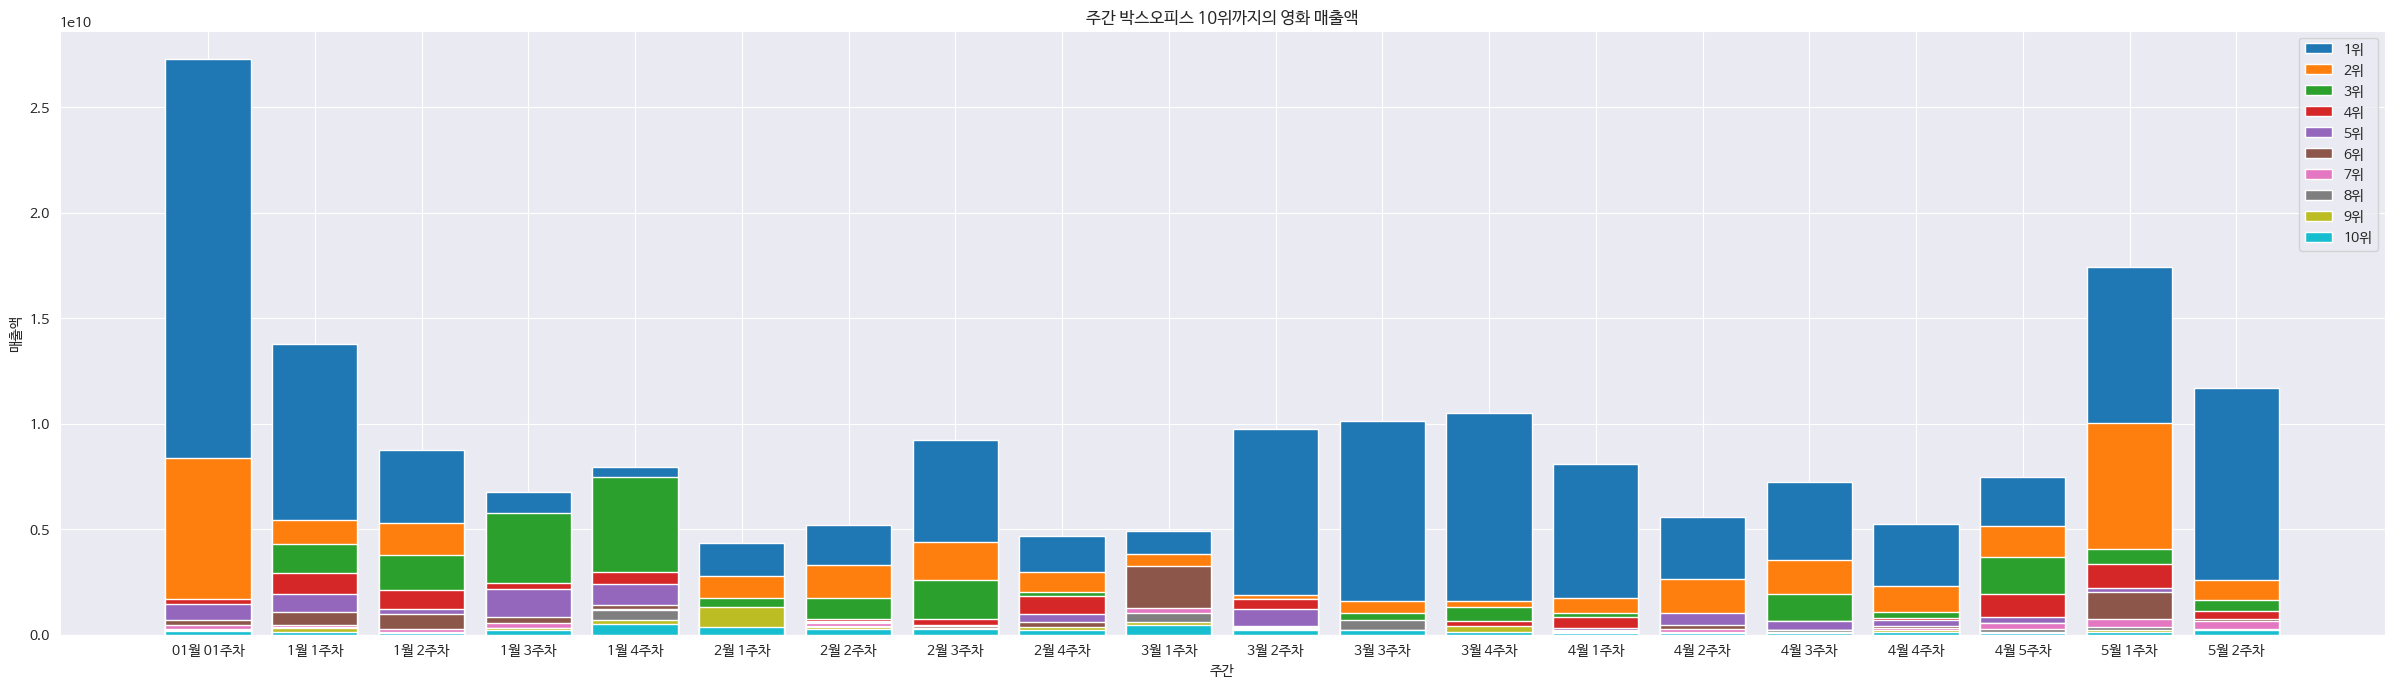

In [93]:
import matplotlib.pyplot as plt
from datetime import datetime

# 나눔바른고딕 폰트로 설정
plt.rc('font', family='NanumBarunGothic')

#그래프 DPI 기본값 변경
plt.rcParams['figure.dpi'] = 100

# 주간별 순위 순서로 데이터프레임 정렬
sorted_df = result.sort_values(['Date', 'Rank'])

# 시각화 설정
plt.figure(figsize=(30, 8))

# 막대 그래프 생성
for rank in range(1, 11):
    movies = sorted_df[sorted_df['Rank'] == rank]
    x_labels = []
    prev_month = None
    week_count = 0
    for date in movies['Date']:
        week_start = datetime.strptime(str(date.date()), '%Y-%m-%d').strftime('%m월 %U주차')
        month = date.month
        if prev_month is None:
            prev_month = month
            x_labels.append(f'{week_start}')
            week_count = 1
        elif month != prev_month:
            x_labels.append(f'{month}월 1주차')
            prev_month = month
            week_count = 2
        else:
            x_labels.append(f'{month}월 {week_count}주차')
            week_count += 1
    plt.bar(x_labels, movies['SalesAmount'], label=f'{rank}위')

# 축과 제목 설정
plt.xlabel('주간')
plt.ylabel('매출액')
plt.title('주간 박스오피스 10위까지의 영화 매출액')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()


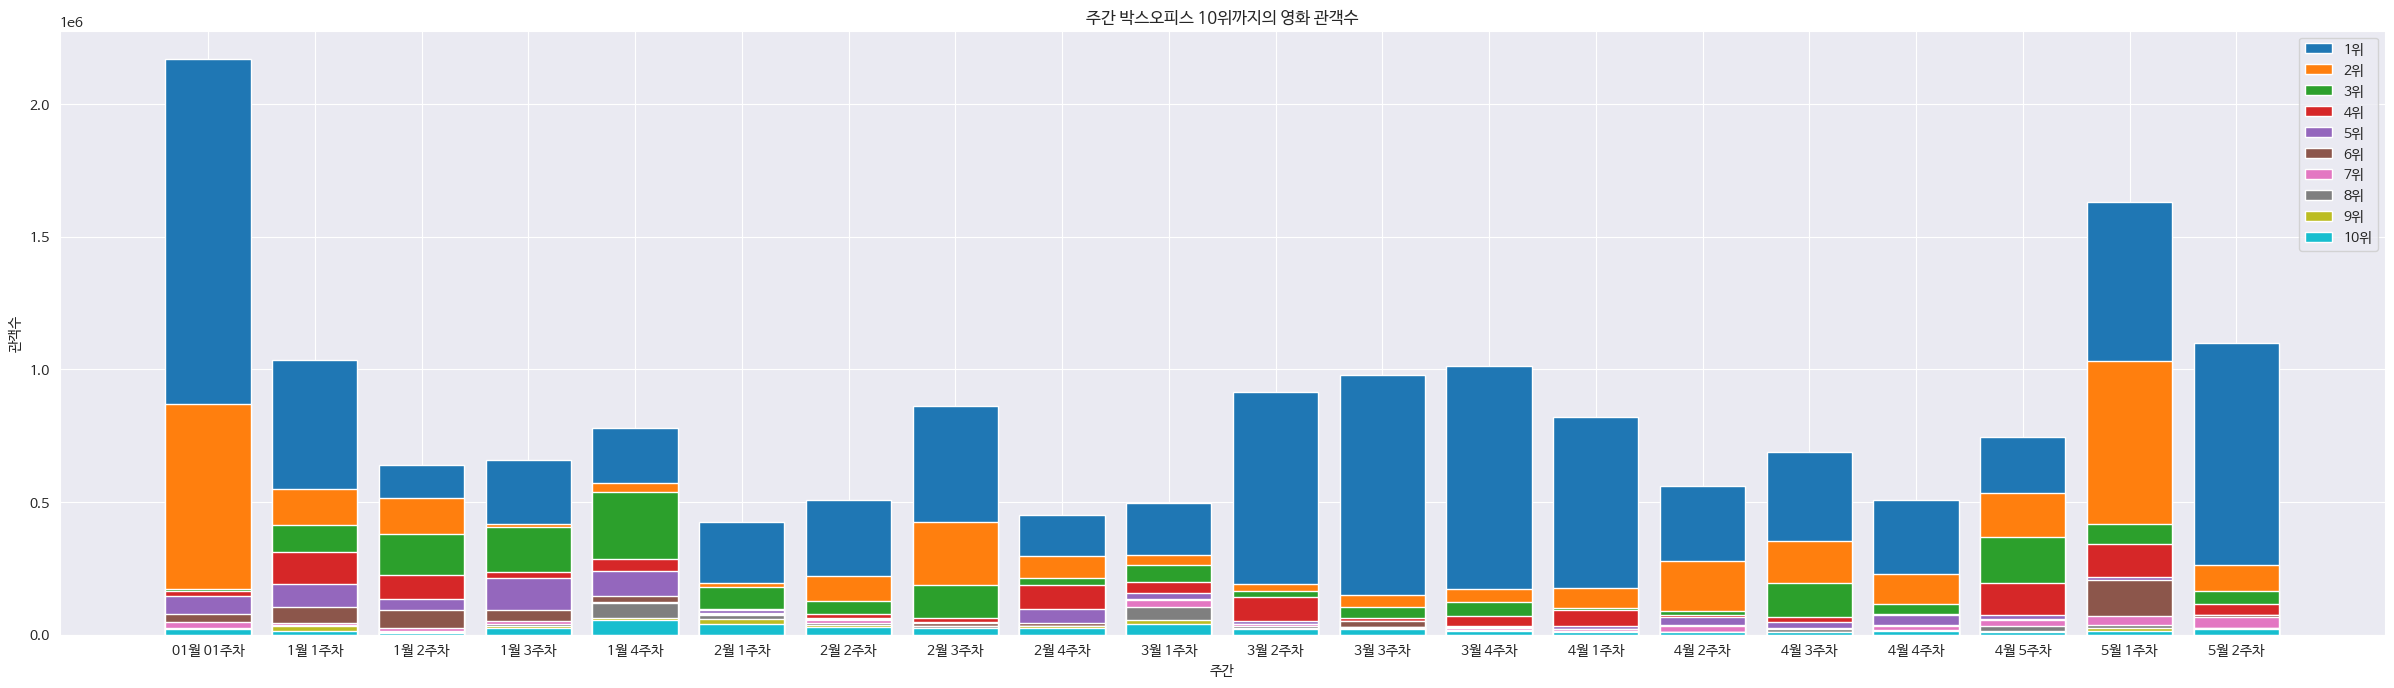

In [94]:
# 주간별 순위 순서로 데이터프레임 정렬
sorted_df = result.sort_values(['Date', 'Rank'])

# 시각화 설정
plt.figure(figsize=(30, 8))

# 막대 그래프 생성
for rank in range(1, 11):
    movies = sorted_df[sorted_df['Rank'] == rank]
    x_labels = []
    prev_month = None
    week_count = 0
    for date in movies['Date']:
        week_start = datetime.strptime(str(date.date()), '%Y-%m-%d').strftime('%m월 %U주차')
        month = date.month
        if prev_month is None:
            prev_month = month
            x_labels.append(f'{week_start}')
            week_count = 1
        elif month != prev_month:
            x_labels.append(f'{month}월 1주차')
            prev_month = month
            week_count = 2
        else:
            x_labels.append(f'{month}월 {week_count}주차')
            week_count += 1
    plt.bar(x_labels, movies['AudienceCount'], label=f'{rank}위')

# 축과 제목 설정
plt.xlabel('주간')
plt.ylabel('관객수')
plt.title('주간 박스오피스 10위까지의 영화 관객수')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()


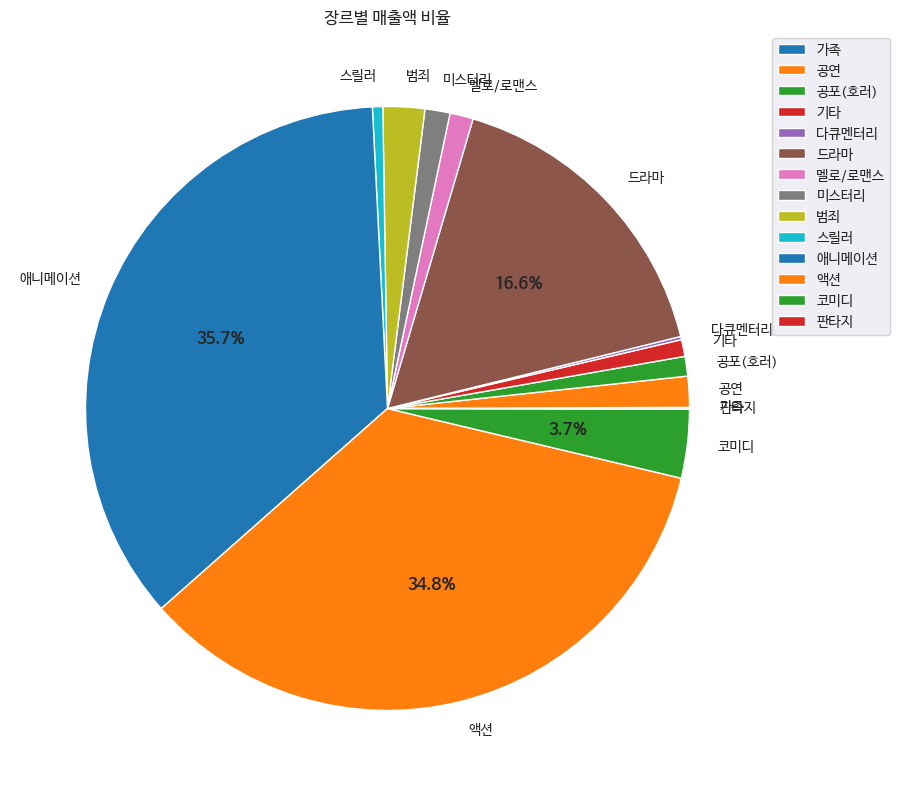

In [103]:
# 장르별 매출액 합산
genre_sales = result.groupby('repGenreNm')['SalesAmount'].sum()

# 시각화 설정
plt.figure(figsize=(10, 10))

# 파이 차트 생성
labels = genre_sales.index
sizes = genre_sales.values
threshold = 3  # 레이블 표시를 위한 비율 임계값
autopct_format = lambda p: f'{p:.1f}%' if p >= threshold else ''
wedges, _, autotexts = plt.pie(sizes, labels=labels, autopct=autopct_format, startangle=0)

# 레이블 위치 조정
plt.setp(autotexts, size=12, weight='bold')  # 레이블 크기 조정

# 범례 위치 조정
plt.legend(wedges, labels, loc='upper left', bbox_to_anchor=(1, 1))

# 파이 차트 회전
plt.gca().set_aspect('equal')

# 제목 설정
plt.title('장르별 매출액 비율')

# 그래프 출력
plt.show()

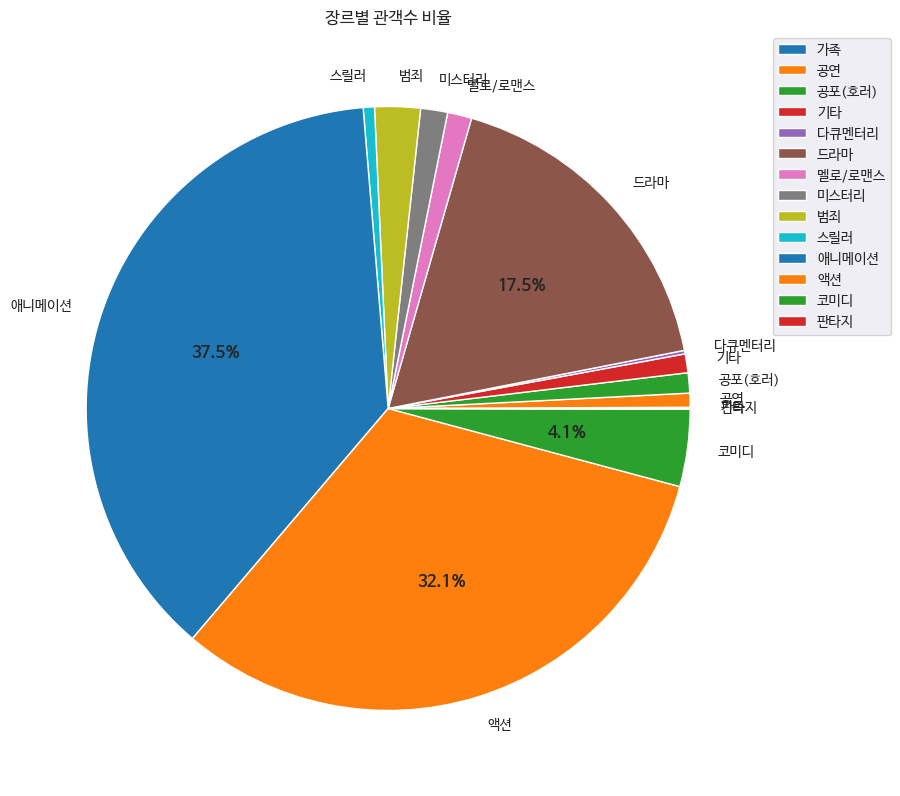

In [96]:
# 장르별 매출액 합산
genre_sales = result.groupby('repGenreNm')['AudienceCount'].sum()

# 시각화 설정
plt.figure(figsize=(10, 10))

# 파이 차트 생성
labels = genre_sales.index
sizes = genre_sales.values
threshold = 3  # 레이블 표시를 위한 비율 임계값
autopct_format = lambda p: f'{p:.1f}%' if p >= threshold else ''
wedges, _, autotexts = plt.pie(sizes, labels=labels, autopct=autopct_format, startangle=0)

# 레이블 위치 조정
plt.setp(autotexts, size=12, weight='bold')  # 레이블 크기 조정

# 범례 위치 조정
plt.legend(wedges, labels, loc='upper left', bbox_to_anchor=(1, 1))

# 파이 차트 회전
plt.gca().set_aspect('equal')

# 제목 설정
plt.title('장르별 관객수 비율')

# 그래프 출력
plt.show()

In [109]:
# 제작국가 상위 3곳
nation_top_3 = result['repNationNm'].value_counts().head(3)
nation_top_3

한국    77
미국    64
일본    45
Name: repNationNm, dtype: int64

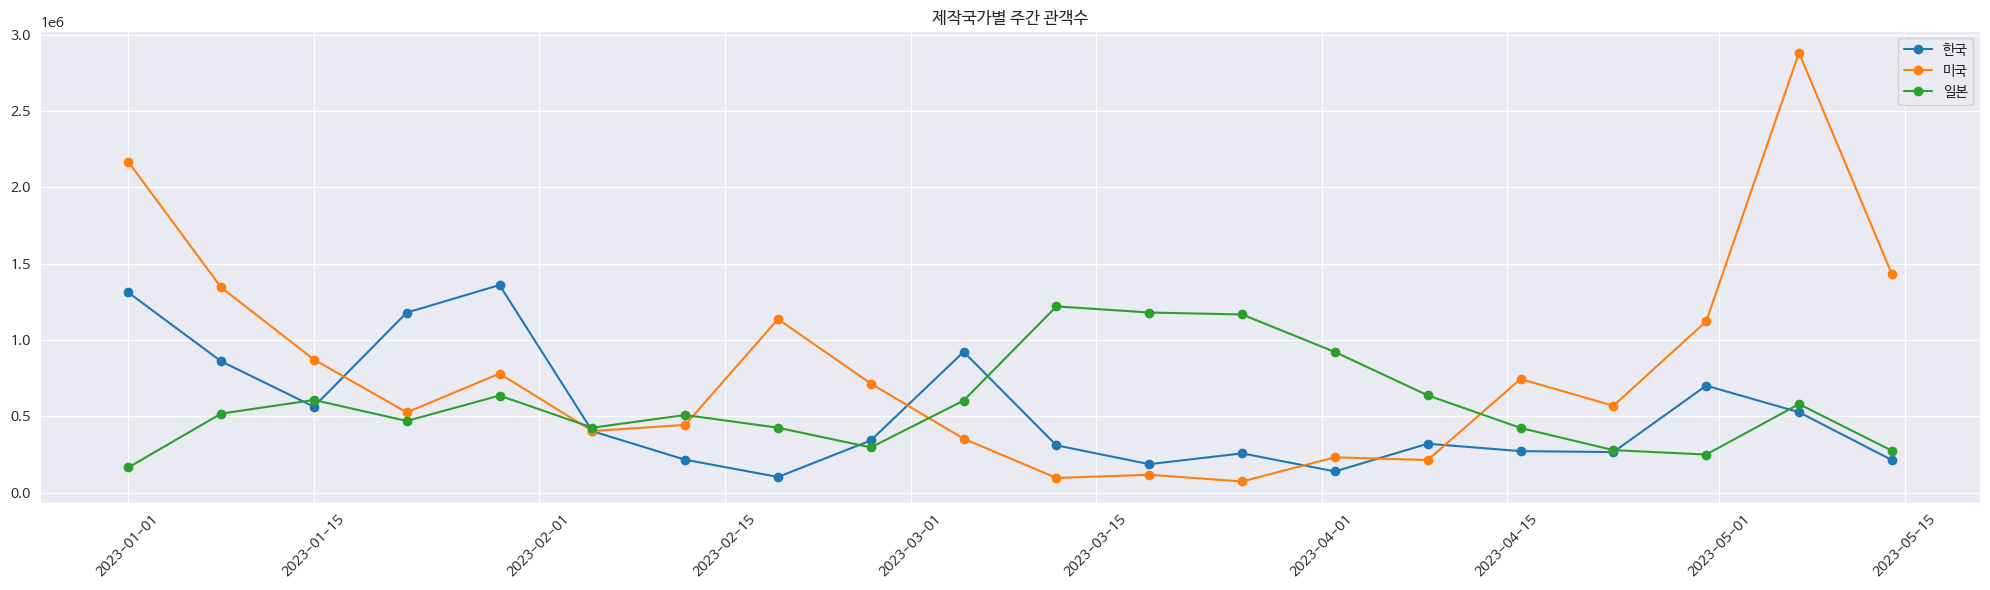

In [120]:
# 각 제작국가별 데이터 선택
line1 = result[result['repNationNm'] == '한국'].groupby('Date')['AudienceCount'].sum()
line2 = result[result['repNationNm'] == '미국'].groupby('Date')['AudienceCount'].sum()
line3 = result[result['repNationNm'] == '일본'].groupby('Date')['AudienceCount'].sum()

fig, ax = plt.subplots(figsize=(20, 6))

# 각 제작국가별 선 그래프 그리기
ax.plot(line1.index, line1.values, marker='o', label='한국', linestyle='-')
ax.plot(line2.index, line2.values, marker='o', label='미국', linestyle='-')
ax.plot(line3.index, line3.values, marker='o', label='일본', linestyle='-')

ax.set_title('제작국가별 주간 관객수')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\yejin\AppData\Local\Temp\ipykernel_18104\2952798253.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc)


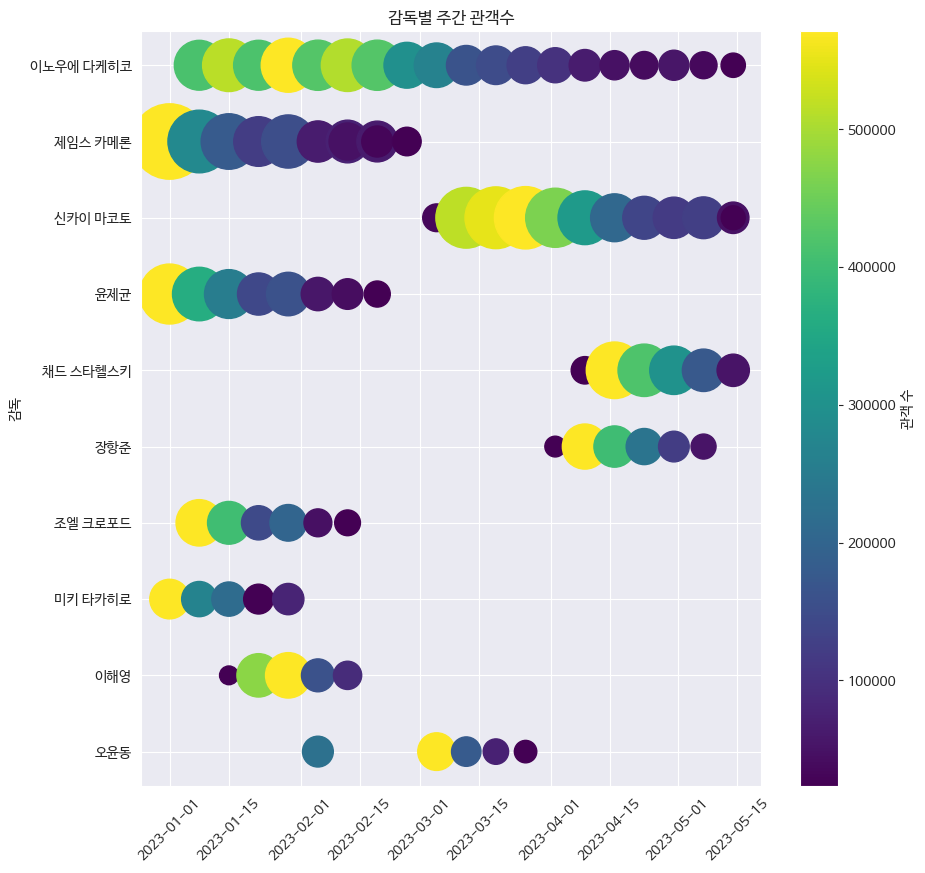

In [150]:
import numpy as np
from matplotlib.cm import ScalarMappable

# 빈 문자열로 된 감독명을 제외한 데이터만 필터링합니다.
filtered_result = result[result['directors'] != '']

top_directors = filtered_result['directors'].value_counts().head(10).index
abbreviated_directors = [director[:10] + '...' if len(director) > 10 else director for director in top_directors]

fig, ax = plt.subplots(figsize=(10, 10))

for director, abbreviated_director in zip(top_directors[::-1], abbreviated_directors[::-1]):
    line = filtered_result[filtered_result['directors'] == director]
    sizes = np.sqrt(line['AudienceCount']) * 2
    sc = ax.scatter(line['Date'], [abbreviated_director] * len(line), c=line['AudienceCount'], s=sizes, cmap='viridis')

# 컬러바 생성 및 레이블 설정
cbar = plt.colorbar(sc)
cbar.set_label('관객 수')

# 레이블과 x축의 위치를 설정합니다.
ax.set_yticks(np.arange(len(top_directors)))
ax.set_yticklabels(abbreviated_directors[::-1])
ax.set_ylabel('감독')

ax.set_title('감독별 주간 관객수')
plt.xticks(rotation=45)

plt.show()
